# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="Images/pic1.png"/>

Then you will want to run the above command:

<img src="Images/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [141]:
#Importing everything we'll need

#General Packages
import math
import json
import os
import datetime

#PyData Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
#Sklearn Packages
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, Imputer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#Magic Commands
%matplotlib inline

In [ ]:
#Reading in the json files
portfolio = pd.read_json('data/portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('data/profile.json', orient = 'records', lines = True)
transcript = pd.read_json('data/transcript.json', orient = 'records', lines = True)

### Preliminary Analysis & Data Preproccesing
###### Now that we have downloaded on the packages and imported the data, we are going to run some prelimnary analysis on the data to  deteremine what needs to be processed and then we move into the rest of the assignment. We will perform this for  three of the datasets. 

In [ ]:
#Looking at the first fiew rows of the portfolio dataset
portfolio.head()

In [ ]:
portfolio.info()

In [ ]:
portfolio['offer_type'].value_counts()

In [ ]:
#Viewing all the channels leveraged
portfolio['channels'].value_counts()


##### Portfolio dataset Clean Up

This is a relatively small dataset so we are juat going to clean up the dataset

- We changed the column name from 'id' to a more intuitive name 'offer_id' since the id column is present in our other datasets
    
- We one hot encoded the 'offer_type' column to work well with our algorithms later in our analysis
   
- We separated and one hot encoded the 'channels' column to also work with our algorithms later in our analysis.

- We Dropped 'offer_type' and 'channels' columns now that we have one hot encoded the features



In [ ]:
#Changing the column name from 'id' to 'offer_id'
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)
portfolio.info()

In [ ]:
#One-hot encoding the offer_type field, fixing a prefix of 'offer'
offer_dummies = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
portfolio = pd.concat([portfolio,offer_dummies], axis = 1)

#After the changes
portfolio.head()

In [ ]:
#One-hot encoding thw channels field
#Please refer to this post on how to onecode multilabel a column : https://chrisalbon.com/machine_learning/preprocessing_structured_data/one-hot_encode_features_with_multiple_labels

#First initialize the MultiBinarizer Object 
one_hot_channels = MultiLabelBinarizer()

#One hot code the portfolio channel data
seperate_channel = one_hot_channels.fit_transform(portfolio['channels'])

#Making a Dataframe with new channels 
channels_df = pd.DataFrame(data = seperate_channel, columns = one_hot_channels.classes_)

#Concatenating the new columns with the old portfolio DataFrame
portfolio = pd.concat([portfolio,channels_df], axis = 1)

#Fixing the channels prefix in the column names
portfolio.rename(columns = {'email': 'channel_email', 'mobile': 'channel_mobile', 'social': 'channel_social', 'web': 'channel_web'}, inplace = True)

#After the changes
portfolio.head()

In [ ]:
#Dropping the now former 'channels' and 'offer_type' columns
portfolio.drop(columns = ['channels', 'offer_type'], axis = 1, inplace = True)

#Viewing our hanges
portfolio.info()

### Profile Dataset

##### Preliminary Analysis

In [ ]:
# Looking at some random rows
profile.head() 

In [ ]:
profile.info()

In [ ]:
#Checking gender types and leaving in the nulls
profile['gender'].value_counts(dropna = False)

In [ ]:
#Checking how many unknown ages (118) are in the dataset
(profile['age'] == 118).sum()


##### Profile Dataset Clean Up

This was a significantly larger dataset which means we will have significantly more changes to it than other datasets

- We Dropped the rows with null information
- We Changed the 'id' column to 'customer_id' name
- We Changed the 'became_member_on' column to a date object type
- We Calculated the number of days that a person has been a member as new 'days_as_member' column as of August 1, 2018
- We  Created the new 'age_range' column based on 'age'



In [ ]:
#Dropping rows with null information
profile.dropna(inplace = True)
profile.info()

In [ ]:
#Changing 'id' column name to more appropriate 'customer_id' name
profile.rename(columns = {'id': 'customer_id'}, inplace = True)
profile.info()

In [ ]:
#Changing 'became_member_on' column to a date type
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())
profile['became_member_on'].head()

In [ ]:
#Calculating number of days as a member ending on August 1,2018 in new column 'days_as_member'
#This stackoverflow post explains clearly how to calculated the number of days elapsed since a certain date 
end_date = pd.Timestamp('2018-08-01')
end_date = pd.to_datetime(end_date)
profile['days_as_member'] = np.abs((pd.to_datetime(profile['became_member_on']) - end_date).dt.days)

#Lets see the changes in the profile datsets 
profile['days_as_member'].head(10)

In [ ]:
#Making an age-range column based on age
#Checkout this stack overflow article for categorising age columns: https://stackoverflow.com/questions/26072087/pandas-number-of-days-elapsed-since-a-certain-date
age_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
age_range_labels = ['11-19','20-29','30-39','40-49','50-59','60-69','70-79','80+']
profile['age_range'] = pd.cut(profile['age'],bins = age_bins,labels = age_range_labels, right = False)

#Lets add an order to the age_range
#You can checkout this post for refrence for catgorsing the age range in order: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html
profile['age_range'] = pd.Categorical(profile['age_range'], ordered=True, categories = age_range_labels)

#After the Changes
profile.sample(5)

##### Transcript Dataset

Initial Analysis

In [ ]:
#Let take a look at the transcript dataset
transcript['value'].value_counts()

In [ ]:
#Checking the information of the transcript for null values and datatypes
transcript.info()

In [ ]:
#Checking the transcript for data types
transcript['event'].value_counts()

### Transcript Dataset Clean Up
- We Changed the name of 'person' column to 'customer_id'
- We Removed customers that are not reflected in the 'profile' dataset
- We One hot encoded the 'event' values
- We Changedthe 'time' column to 'days' along with the appropriate values
- We seperated the value from key in 'value' dictionary to form two new DataFrames: transcript_offer and transcript_amount


In [ ]:
transcript.sample(10)

In [ ]:
#Changing the 'person' Category name to 'customer-id'
transcript.rename(columns = {'person':'customer_id'}, inplace = True)
transcript.info()

In [ ]:
#Remove customers not found in the 'profile dataset
#Checkout this post on merge data: https://datacarpentry.org/python-ecology-lesson/05-merging-data/
transcript = pd.merge(left = transcript, right = profile, how = 'inner', left_on = 'customer_id', right_on = 'customer_id')
transcript.drop(columns = ['age', 'became_member_on', 'gender', 'income', 'days_as_member', 'age_range'], inplace = True)

#After results
transcript.info()

In [ ]:
#Lets say encode the 'event' values
#Checkout to this stack overflow article for get_dummies: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
event_dummies = pd.get_dummies(transcript['event'])
event_dummies.rename(columns = {'offer completed': 'offer_completed','offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
transcript = pd.concat([transcript,event_dummies],axis = 1)
transcript.head()

In [27]:
#changing the 'time' column to 'days' 
transcript['days'] = transcript['time']/24
transcript.drop(columns = ['time'], inplace = True)
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      272762 non-null  object 
 1   event            272762 non-null  object 
 2   value            272762 non-null  object 
 3   offer_completed  272762 non-null  uint8  
 4   offer_received   272762 non-null  uint8  
 5   offer_viewed     272762 non-null  uint8  
 6   transaction      272762 non-null  uint8  
 7   days             272762 non-null  float64
dtypes: float64(1), object(3), uint8(4)
memory usage: 11.4+ MB


In [28]:
#Form two new DataFrame using the keys and values from the value column: transcript_offer and transcript_amount
#Checkout this stack overflow article on how to extract the dictionary value from column in data-frame: https://stackoverflow.com/questions/35711059/extract-dictionary-value-from-column-in-data-frame

#Initial seperation
transcript['offer-or-amount'] = transcript['value'].apply(lambda x : list(x.keys())[0])
transcript['id-or-amount'] = transcript['value'].apply(lambda x : list(x.values())[0])

#Correcting for all instances 'offer id' to read 'offer_id' consisently
trans_offer_dict = {'offer id': 'offer_id'}
transcript['offer-or-amount'].replace(trans_offer_dict, inplace = True)

#Making the transcript offer DataFrame 
transcript_offer = transcript[transcript['offer-or-amount'] == 'offer_id']
transcript_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
transcript_offer.drop(columns = ['event','value', 'offer-or-amount', 'transaction'], inplace = True)

#Making the transcript amount DataFrame
transcript_amount = transcript[transcript['offer-or-amount'] == 'amount']
transcript_amount.rename(columns = {'id-or-amount':'amount'}, inplace = True)
transcript_amount.drop(columns = ['event','value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)

transcript_amount.head(10)


C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,customer_id,transaction,days,amount
2,78afa995795e4d85b5d9ceeca43f5fef,1,5.50,19.89
4,78afa995795e4d85b5d9ceeca43f5fef,1,6.00,17.78
7,78afa995795e4d85b5d9ceeca43f5fef,1,9.25,19.67
8,78afa995795e4d85b5d9ceeca43f5fef,1,10.00,29.72
9,78afa995795e4d85b5d9ceeca43f5fef,1,15.75,23.93
13,78afa995795e4d85b5d9ceeca43f5fef,1,21.25,21.72
16,78afa995795e4d85b5d9ceeca43f5fef,1,22.25,26.56
20,e2127556f4f64592b11af22de27a7932,1,12.00,17.88
21,e2127556f4f64592b11af22de27a7932,1,12.25,21.43
27,e2127556f4f64592b11af22de27a7932,1,21.75,18.42


### Exploratory Data Analysis

Since we have done an initial analysis and cleaning. We are going to do a more formal analysis to see how we might need top pre-process our data even further down in formal data pre-processing. 
We will break down what the data actually refelcts

In [38]:
#Initializing my preferred color choices
my_crimson_color =  '#DC143C'
my_blue_color = '#0000FF'

### Q1:LETS CHECK OUT THE AGE RANGES OF OUR CUSTOMERS?
Given that young people anedoctally are known to consume more coffee and are enamoured by the starbucks brand, i have a suspicion the trend will be skewed in their directions

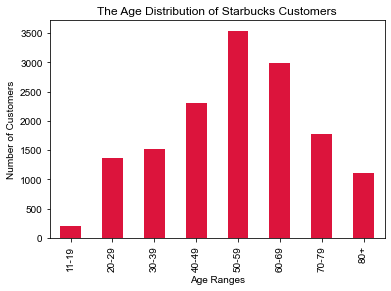

In [39]:
#Viewing the age ranges of our Stabucks customers
profile['age_range'].value_counts().sort_index().plot(kind = 'bar', color = my_crimson_color);
plt.title('The Age Distribution of Starbucks Customers');
plt.style.use('seaborn');
plt.ylabel('Number of Customers');
plt.xlabel('Age Ranges');

### A1: The actual age distributions of Starbucks customers.
It would seem like that from the data shows that the largest purchaser seems to be people in their 40's , 50's and 60's range which probably means that the starbucks have become an hangout spot for those close to retirement or already retired. This speaks to the fact that the older one gets , the more likey they are able to afford starbucks high steeped prices of coffee,This might be another reason. 

### Q2:What does the correlation between number of days an offer has been vs. final transaction amount have to tell us ?

The correlation might be that since an offer has been open fpr an extended period of time, The customer might not feel particularly that excited about it. A More enthuastic customer would have claimed the reward earlier, for fear of missing out on the reward.Lets move on and see what the data has to say about this concept

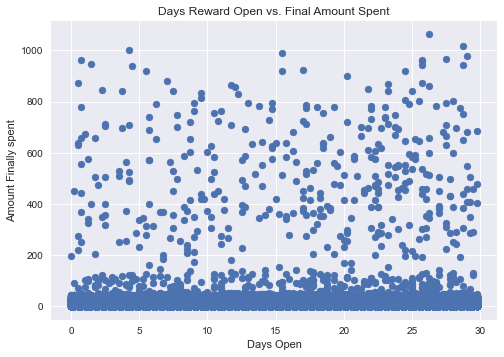

In [31]:
#Visualizing the days spent vs anount spent in a scatter plot
plt.scatter(data = transcript_amount, x = 'days', y = 'amount');
plt.title('Days Reward Open vs. Final Amount Spent');
plt.xlabel('Days Open');
plt.ylabel('Amount Finally spent');
plt.style.use('seaborn');

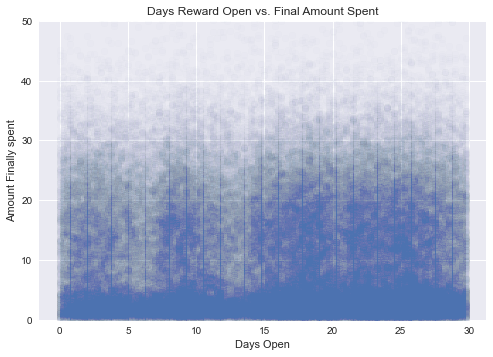

In [32]:
#Visualizing the days open vs amount spent in a scatter plot in a more limited view
plt.scatter(data = transcript_amount, x = 'days', y = 'amount', alpha = .01);
plt.title('Days Reward Open vs. Final Amount Spent');
plt.xlabel('Days Open');
plt.ylabel('Amount Finally spent');
plt.style.use('seaborn');
plt.ylim(0,50);

### A2: Analysis of amount spent vs. Days Open
There seems to be no correlation between thr amount spent and the days the offer was left open. This is clarified bu the two scacatter plots which shows there were no correlation between the two 


### Q3: Does gender have any effect on the data ?
Lets take a dive into how gender might have an effect on the videos. Our dataset have three indistinct genders: Male, Female, and Other

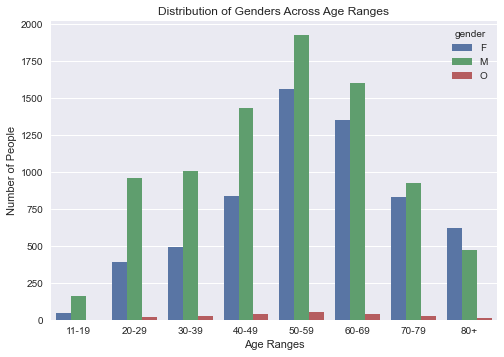

In [33]:
#Visualizing the gender distribution in a seaborn count plot
sb.countplot(data = profile,x = 'age_range', hue = 'gender')
plt.title('Distribution of Genders Across Age Ranges');
plt.xlabel('Age Ranges');
plt.ylabel('Number of People');
plt.style.use('seaborn');


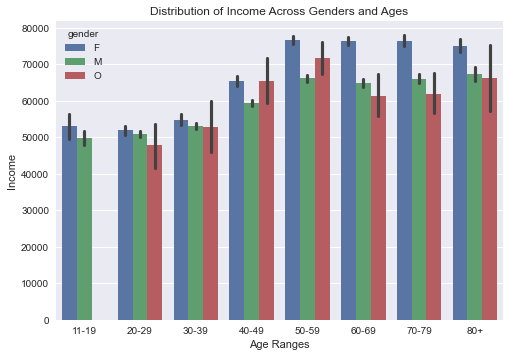

In [34]:
#Visualizing the gender/income/age range distribution in a seaborn bar plot
sb.barplot(data = profile, x = 'age_range', y = 'income', hue = 'gender');
plt.title('Distribution of Income Across Genders and Ages');
plt.xlabel('Age Ranges');
plt.ylabel('Income');
plt.style.use('seaborn');

### A3: Analysis of gender across our customer data
The first plot did not suprise me at all , i had a feeling that since its the general sentiment that men made more money, then its only normal the had more income,However the second plot nullifies that point and shows that women had higher income on average across the age ranges, even though there was not much disparity between the income ranges.I was really suprised by this plot Prediction

### Q4: What are the salary ranges of people across different age groups

I wanted to see how the salary ranges of these various age groups might affect how often a person visits Starbucks and use their rewards program. My hypothesis is that the older you are the higher you earn and are more likely to buy more


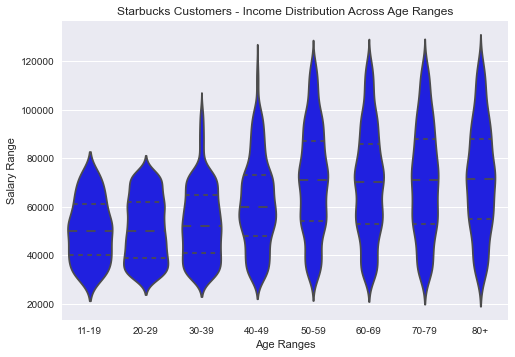

In [35]:
#Visualizing the data in a violin plot
sb.violinplot(data = profile, x = 'age_range', y = 'income', color = my_blue_color, inner = 'quartile');
plt.title('Starbucks Customers - Income Distribution Across Age Ranges');
plt.xlabel('Age Ranges')
plt.ylabel('Salary Range')
plt.style.use('seaborn')

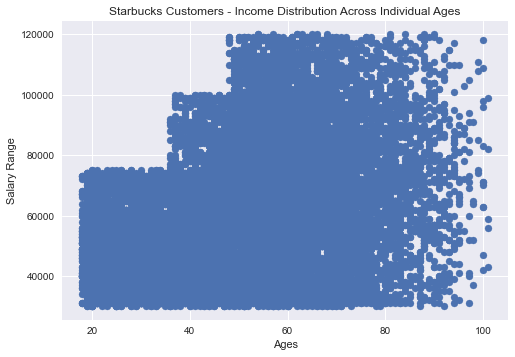

In [36]:
#Visualizing the data in a scatter plot using individual ages instead of age ranges
plt.scatter(data = profile, x = 'age', y = 'income');
plt.title('Starbucks Customers - Income Distribution Across Individual Ages');
plt.xlabel('Ages');
plt.ylabel('Salary Range');
plt.style.use('seaborn');

 ### A4: Analysis of Income Distribution
 When visualizing the data with the violin plots, My hypothesis was confirmed  that older customers definitely tend to make more money;There seemed to be an hard cap at 80,000 on the salary range for young people while for old people the hard cap its 120,000. I think the problem is that i know people in thier 20's and 30's don't have that salary cap so that might be as a result of the data gathered 
 

##  


### Data Preprocessing

With initial analysis / clean up and EDA under our belt, let's move on into formalizing some data preprocessing before we move into modeling the data with some unsupervised models. First, we'll formalize what we already did above for our individual dataset into their own respective functions, and next, we'll start combining these datasets appropriately given our insights gleaned from our exploratory data analysis.


In [3]:
#Function to clean up portfolio

def clean_portfolio(portfolio = portfolio):
    #Changing the column name from 'id' to 'offer_id'
    portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)
    
    #One hot encoding the offer_type field, fixing a prefix of 'offer'
    offer_dummies = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
    portfolio = pd.concat([portfolio, offer_dummies], axis = 1)
    
    #Separating and one hot encoding the channels field
    channels_one_hot = MultiLabelBinarizer()
    sep_channels = channels_one_hot.fit_transform(portfolio['channels'])
    channels_df = pd.DataFrame(data = sep_channels, columns = channels_one_hot.classes_)
    portfolio = pd.concat([portfolio, channels_df], axis = 1)
    portfolio.rename(columns = {'email': 'channel_email', 'mobile': 'channel_mobile', 'social': 'channel_social', 'web': 'channel_web'}, inplace = True)
    
    #Dropping the now former columns
    portfolio.drop(columns = ['channels', 'offer_type'], axis = 1, inplace = True)
    
    return portfolio

portfolio_clean = clean_portfolio()
portfolio_clean.head()
    

,reward,difficulty,duration,offer_id,offer_bogo,offer_discount,offer_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


In [4]:
#Function to clean up profile
def clean_profile(profile = profile):
    #Dropping rows with null information
    profile.dropna(inplace = True)
    
    #Changing 'id' column name to more appropriate 'customer_id' name
    profile.rename(columns = {'id': 'customer_id'}, inplace = True)
    
    #Changing 'became_member_on' column to a date type
    profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())
    
    #Calculating number of days as a member ending on August 1, 2018 in new column 'days_as_member'
    end_date = pd.Timestamp('2018-08-01')
    end_date = pd.to_datetime(end_date)
    profile['days_as_member'] = np.abs((pd.to_datetime(profile['became_member_on']) - end_date).dt.days)
    
    #Creating 'age_range' column based on 'age'
    age_range_labels = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
    age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
    profile['age_range'] = pd.cut(profile['age'], bins = age_range_bins, labels = age_range_labels, right = False)

    #Adding a specific order to the age_range_field
    profile['age_range'] = pd.Categorical(profile['age_range'], ordered = True, categories = age_range_labels)
    return profile

profile_clean = clean_profile()
profile_clean.head()

,gender,age,customer_id,became_member_on,income,days_as_member,age_range
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,382,50-59
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,449,70-79
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,97,60-69
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,173,60-69
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,263,50-59


In [40]:
#Function to clean up transcript
def clean_transcript(transcript = transcript):
    #Changing the 'person' category name to 'customer_id'
    transcript.rename(columns = {'person': 'customer_id'}, inplace = True)
    
    #Remove customers not found in the 'profile dataset'
    transcript = pd.merge(left = transcript, right = profile, how = 'inner', left_on = 'customer_id', right_on = 'customer_id')
    transcript.drop(columns = ['age', 'became_member_on', 'gender', 'income', 'days_as_member', 'age_range'], inplace = True)
    
    #One hot encode event values
    event_dummies = pd.get_dummies(transcript['event'])
    event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
    transcript = pd.concat([transcript, event_dummies], axis = 1)
    
    #Change 'time' column to 'days' along with the appropriate values
    transcript['days'] = transcript['time'] / 24
    transcript.drop(columns = ['time'], inplace = True)
    
    #Separate value from key in 'value' dictionary to form two new DataFrames: transcript_offer and transcript_amount

    #Initial separation
    transcript['offer-or-amount'] = transcript['value'].apply(lambda x: list(x.keys())[0])
    transcript['id-or-amount'] = transcript['value'].apply(lambda x: list(x.values())[0])

    #Conforming 'offer id' to read 'offer_id' consistently
    trans_offer_dict = {'offer id': 'offer_id'}
    transcript['offer-or-amount'].replace(trans_offer_dict, inplace = True)

    #Creating the transcript_offer DataFrame
    transcript_offer = transcript[transcript['offer-or-amount'] == 'offer_id']
    transcript_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
    transcript_offer.drop(columns = ['event', 'value', 'offer-or-amount', 'transaction'], inplace = True)

    #Creating the transcript_amount DataFrame
    transcript_amount = transcript[transcript['offer-or-amount'] == 'amount']
    transcript_amount.rename(columns = {'id-or-amount': 'amount'}, inplace = True)
    transcript_amount.drop(columns = ['event', 'value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)

    return transcript_offer, transcript_amount

transcript_offer_clean, transcript_amount_clean = clean_transcript()
print(transcript_offer_clean)
print(transcript_amount_clean)

KeyError: 'time'

### Master Processing: Customer Transactions

With our individual dataset cleaning defined across separate functions, we're now going to create a function that builds a master DataFrame of customer transactions, 'customer_transactions.' In the function below, we're going to take several things in mind to engineer some new feature that I feel will be helpful when we actually move toward running our unsupervised algorithms. Once this master dataset is processed, each row will represent an individual customer and contain the following columns / features.

### Features:

- customer_id: The unique customer identifier
- age: The age of the customer
- age_range: The age range the customer falls into
- gender: The gender of the customer, either male (M), female (F), or other (O)
- income: How much money the customer makes each year
- became_member_on: The date that the customer because a Starbucks Rewards member
- days_as_member: How many days that the customer has been a Starbucks Rewards member
- total_completed: The total number of offers actually completed by the customer
- total_received: The total number of offers that Starbucks sent to the customer
- total_viewed: The total number of offers that the customer viewed
- percent_completed: The ratio of offers that the customer completed as compared to how many offers Starbucks sent to the customer
- total_spent: The total amount of money spent by the customer across all transactions
- avg_spent: The mean average amount of money spent by the customer across all transactions
- num_transactions: The total amount of individual monetary transactions performed by the customer
- completed_bogo: The number of completed BOGO offers by the customer
- num_bogos: The total number of BOGO offers sent to the customer by Starbucks
- bogo_percent_completed: The ratio of how many BOGO offers were actually completed by the customer as compared to how many Starbucks sent them
- completed_discount: The number of completed discount offers by the customer
- num_discounts: The number of discount offers sent to the customer by Starbucks
- discount_percent_completed: The ratio of how many discount offers were actually completed by the customer as compared to how many Starbucks sent them



In [29]:
#Creating a function that will build our master DataFrame_customer transactions
#Special thanks to this post for assisting how to append DataFrames: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

def generate_transactions(customer_ids, portfolio = portfolio, profile = profile, transcript_offer = transcript_offer, transcript_amount = transcript_amount):
    
    #Initializing a list to append our individual customer dictionaries to
    person_entries = []
    
    for customer_id in customer_ids:
        #Pulling customer attributes from the 'profile' DataFrame
        customer_attributes = profile[profile['customer_id'] == customer_id]
        age = customer_attributes['age'].values[0]
        became_member_on = customer_attributes['became_member_on'].values[0]
        gender = customer_attributes['gender'].values[0]
        income = customer_attributes['income'].values[0]
        days_as_member = customer_attributes['days_as_member'].values[0]
        age_range = customer_attributes['age_range'].values[0]

        #Initializing variables we will use later on down
        customer_transactions = pd.DataFrame()
        num_discounts = 0
        num_bogos = 0

        #Establishing new features from respective transcript_offer and transcript_amount DataFrames
        total_viewed = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_viewed'].sum()
        total_received = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_received'].sum()
        total_completed = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_completed'].sum()
        total_spent = transcript_amount[transcript_amount['customer_id'] == customer_id]['amount'].sum()
        avg_spent = transcript_amount[transcript_amount['customer_id'] == customer_id]['amount'].mean()
        num_transactions = transcript_amount[transcript_amount['customer_id'] == customer_id]['transaction'].sum()

        #Determining percentage of completed bogo and discount offers
        if total_viewed > 0:
            percent_completed = total_completed / total_received
        else:
            percent_completed = 0

        #Determining the completed offers in order to determine the completed bogos and completed discounts
        offer_completed_df = transcript_offer[transcript_offer['customer_id'] == customer_id]
        completed_offer_list = offer_completed_df['offer_id'].tolist()
        completed_bogo = portfolio[portfolio['offer_id'].isin(completed_offer_list)]['offer_bogo'].sum()
        completed_discount = portfolio[portfolio['offer_id'].isin(completed_offer_list)]['offer_discount'].sum()

        #Determining all the offers received by an individual customer
        offers_received = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_id'].values.tolist()

        #Determining whether or not offer is a bogo or discount offer and incrementing appropriate variables
        for x in offers_received:
            #Iterating through all the bogo offers
            if x in ['ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0', '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'f19421c1d4aa40978ebb69ca19b0e20d']:
                num_bogos += 1
            #Iterating through all the discount offers
            elif x in ['0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2', 'fafdcd668e3743c1bb461111dcafc2a4', '2906b810c7d4411798c6938adc9daaa5']:
                num_discounts += 1

        #Determining the percentage of bogo & discount offers actually completed versus how many of each were offered
        if num_bogos > 0:
            bogo_percent_completed = completed_bogo / num_bogos
        else:
            bogo_perecent_completed = 0.0

        if num_discounts > 0:
            discount_percent_completed = completed_discount / num_discounts
        else:
            discount_percent_completed = 0.0

        #Adding all features to a unified dictionary, 'person_entry'
        person_entry = {'customer_id': customer_id,
                        'age': age,
                        'age_range': age_range,
                        'gender': gender,
                        'income': income,
                        'became_member_on': became_member_on,
                        'days_as_member': days_as_member,
                        'total_completed': total_completed,
                        'total_viewed': total_viewed,
                        'total_received': total_received,
                        'percent_completed': percent_completed,
                        'total_spent': total_spent,
                        'avg_spent': avg_spent,
                        'num_transactions': num_transactions,
                        'completed_bogo': completed_bogo,
                        'num_bogos': num_bogos,
                        'bogo_percent_completed': bogo_percent_completed,
                        'completed_discount': completed_discount,
                        'num_discounts': num_discounts,
                        'discount_percent_completed': discount_percent_completed}

        #Appending person_entry to master customer_transactions DataFrame
        person_entries.append(person_entry)
    
    #Building our final DataFrame from the person_entries list
    customer_transactions = pd.DataFrame(person_entries)
    
    return customer_transactions


## WARNING

The following cell to actually build this master dataset took my personal laptop, a 2018 MacBook Pro, almost 45 minutes to build. Please note this may take your machine a long time to process.


###### Generating a list of customer ids to iterate through
customer_ids = profile['customer_id'].to_list()

#Iterate through customer IDs to form master customer_transactions DataFrame
customer_transactions = generate_transactions(customer_ids)
customer_transactions.head()

In [30]:
#Generating a list of customer ids to iterate through
customer_ids = profile['customer_id'].to_list()

#Iterate through customer IDs to form master customer_transactions DataFrame
customer_transactions = generate_transactions(customer_ids)
customer_transactions.head()

,customer_id,age,age_range,gender,income,became_member_on,days_as_member,total_completed,total_viewed,total_received,percent_completed,total_spent,avg_spent,num_transactions,completed_bogo,num_bogos,bogo_percent_completed,completed_discount,num_discounts,discount_percent_completed
0,0610b486422d4921ae7d2bf64640c50b,55,50-59,F,112000.0,2017-07-15,382,1,0,2,0.000000,77.01,25.670000,3,1,2,0.500000,0,0,0.000000
1,78afa995795e4d85b5d9ceeca43f5fef,75,70-79,F,100000.0,2017-05-09,449,3,4,4,0.750000,159.27,22.752857,7,3,9,0.333333,0,0,0.000000
2,e2127556f4f64592b11af22de27a7932,68,60-69,M,70000.0,2018-04-26,97,2,3,4,0.500000,57.73,19.243333,3,1,3,0.333333,2,5,0.400000
3,389bc3fa690240e798340f5a15918d5c,65,60-69,M,53000.0,2018-02-09,173,5,6,6,0.833333,36.43,12.143333,3,2,11,0.181818,2,6,0.333333
4,2eeac8d8feae4a8cad5a6af0499a211d,58,50-59,M,51000.0,2017-11-11,263,1,2,3,0.333333,15.62,3.905000,4,0,0,0.181818,2,5,0.400000


In [31]:
#Saving to CSV
customer_transactions.to_csv('customer_transactions.csv', index = False)

In [32]:
#Reading back in from CSV
#index_col = "customer_id"
customer_transactions = pd.read_csv('customer_transactions.csv', index_col = "customer_id")

In [33]:
customer_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 0610b486422d4921ae7d2bf64640c50b to e4052622e5ba45a8b96b59aba68cf068
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         14825 non-null  int64  
 1   age_range                   14825 non-null  object 
 2   gender                      14825 non-null  object 
 3   income                      14825 non-null  float64
 4   became_member_on            14825 non-null  object 
 5   days_as_member              14825 non-null  int64  
 6   total_completed             14825 non-null  int64  
 7   total_viewed                14825 non-null  int64  
 8   total_received              14825 non-null  int64  
 9   percent_completed           14825 non-null  float64
 10  total_spent                 14825 non-null  float64
 11  avg_spent                   14492 non-null  float64
 12  num_transactions            14825 n

In [134]:
# We are going to save this Dataframe for our final analysis and visulisation during the final year end of this project 
#Reading back in from CSV
customer_transactions_analysis = pd.read_csv('customer_transactions.csv', index_col = "customer_id")



### Feature Selection
We are going to drop some features from our customer_transaction Dataframe. The reasons for this removal can be shown below:
- **became_member_on**: a date column that can't be scaled
- **age_range**: a categorical column that can't be scaled



In [35]:
#Dropping columns
cols_to_drop = ['became_member_on', 'age_range']
customer_transactions.drop(columns = cols_to_drop, inplace = True)

In [36]:
#I should have done this before, so I'm doing it now
#The gender column needs numerically categorized
gender_dict = {'M': 0, 'F': 1, 'O': 2}
customer_transactions['gender'].replace(gender_dict, inplace = True)
customer_transactions.head()

,age,gender,income,days_as_member,total_completed,total_viewed,total_received,percent_completed,total_spent,avg_spent,num_transactions,completed_bogo,num_bogos,bogo_percent_completed,completed_discount,num_discounts,discount_percent_completed
customer_id,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,1,112000.0,382,1,0,2,0.000000,77.01,25.670000,3,1,2,0.500000,0,0,0.000000
78afa995795e4d85b5d9ceeca43f5fef,75,1,100000.0,449,3,4,4,0.750000,159.27,22.752857,7,3,9,0.333333,0,0,0.000000
e2127556f4f64592b11af22de27a7932,68,0,70000.0,97,2,3,4,0.500000,57.73,19.243333,3,1,3,0.333333,2,5,0.400000
389bc3fa690240e798340f5a15918d5c,65,0,53000.0,173,5,6,6,0.833333,36.43,12.143333,3,2,11,0.181818,2,6,0.333333
2eeac8d8feae4a8cad5a6af0499a211d,58,0,51000.0,263,1,2,3,0.333333,15.62,3.905000,4,0,0,0.181818,2,5,0.400000


In [37]:
#Filling in avg_amount null values with Imputer
imputer = Imputer(strategy = 'median')
cust_trans_imputed = pd.DataFrame(imputer.fit_transform(customer_transactions))

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [38]:
cust_trans_imputed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,55.0,1.0,112000.0,382.0,1.0,0.0,2.0,0.000000,77.01,25.670000,3.0,1.0,2.0,0.500000,0.0,0.0,0.000000
1,75.0,1.0,100000.0,449.0,3.0,4.0,4.0,0.750000,159.27,22.752857,7.0,3.0,9.0,0.333333,0.0,0.0,0.000000
2,68.0,0.0,70000.0,97.0,2.0,3.0,4.0,0.500000,57.73,19.243333,3.0,1.0,3.0,0.333333,2.0,5.0,0.400000
3,65.0,0.0,53000.0,173.0,5.0,6.0,6.0,0.833333,36.43,12.143333,3.0,2.0,11.0,0.181818,2.0,6.0,0.333333
4,58.0,0.0,51000.0,263.0,1.0,2.0,3.0,0.333333,15.62,3.905000,4.0,0.0,0.0,0.181818,2.0,5.0,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,45.0,1.0,54000.0,58.0,0.0,3.0,3.0,0.000000,20.03,2.861429,7.0,1.0,2.0,0.500000,1.0,2.0,0.500000
14821,61.0,0.0,72000.0,19.0,1.0,1.0,3.0,0.333333,25.97,3.710000,7.0,1.0,2.0,0.500000,0.0,0.0,0.000000
14822,49.0,0.0,73000.0,552.0,0.0,1.0,3.0,0.000000,39.74,4.967500,8.0,0.0,0.0,0.500000,1.0,1.0,1.000000
14823,83.0,1.0,50000.0,877.0,3.0,3.0,3.0,1.000000,189.67,13.547857,14.0,3.0,9.0,0.333333,0.0,0.0,0.000000


In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(cust_trans_imputed)

In [40]:
data_rescaled

array([[0.44578313, 0.5       , 0.91111111, ..., 0.        , 0.        ,
        0.        ],
       [0.68674699, 0.5       , 0.77777778, ..., 0.        , 0.        ,
        0.        ],
       [0.60240964, 0.        , 0.44444444, ..., 0.5       , 0.29411765,
        0.4       ],
       ...,
       [0.37349398, 0.        , 0.47777778, ..., 0.25      , 0.05882353,
        1.        ],
       [0.78313253, 0.5       , 0.22222222, ..., 0.        , 0.        ,
        0.        ],
       [0.53012048, 0.5       , 0.57777778, ..., 0.25      , 0.17647059,
        0.33333333]])

In [41]:
#Making  a new DataFramefor Visualisation and analysis 
column_names = customer_transactions.columns.values.tolist()
customer_transactions_master = pd.DataFrame(data_rescaled, columns = column_names)
customer_transactions_master.head()

,age,gender,income,days_as_member,total_completed,total_viewed,total_received,percent_completed,total_spent,avg_spent,num_transactions,completed_bogo,num_bogos,bogo_percent_completed,completed_discount,num_discounts,discount_percent_completed
0,0.445783,0.5,0.911111,0.206253,0.166667,0.000000,0.333333,0.000000,0.047871,0.056545,0.083333,0.25,0.111111,0.454545,0.0,0.000000,0.000000
1,0.686747,0.5,0.777778,0.243006,0.500000,0.666667,0.666667,0.750000,0.099006,0.050082,0.194444,0.75,0.500000,0.272727,0.0,0.000000,0.000000
2,0.602410,0.0,0.444444,0.049918,0.333333,0.500000,0.666667,0.500000,0.035886,0.042306,0.083333,0.25,0.166667,0.272727,0.5,0.294118,0.400000
3,0.566265,0.0,0.255556,0.091607,0.833333,1.000000,1.000000,0.833333,0.022646,0.026574,0.083333,0.50,0.611111,0.107438,0.5,0.352941,0.333333
4,0.481928,0.0,0.233333,0.140976,0.166667,0.333333,0.500000,0.333333,0.009710,0.008320,0.111111,0.00,0.000000,0.107438,0.5,0.294118,0.400000


In [42]:
#Remember tp set index column as a data
customer_transactions_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         14825 non-null  float64
 1   gender                      14825 non-null  float64
 2   income                      14825 non-null  float64
 3   days_as_member              14825 non-null  float64
 4   total_completed             14825 non-null  float64
 5   total_viewed                14825 non-null  float64
 6   total_received              14825 non-null  float64
 7   percent_completed           14825 non-null  float64
 8   total_spent                 14825 non-null  float64
 9   avg_spent                   14825 non-null  float64
 10  num_transactions            14825 non-null  float64
 11  completed_bogo              14825 non-null  float64
 12  num_bogos                   14825 non-null  float64
 13  bogo_percent_completed      148

In [43]:
### We clean out the dataset for emptyvalues 
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
customer_transactions_master = clean_dataset(customer_transactions_master)

In [44]:
#Saving to CSV
customer_transactions_master.to_csv('customer_transactions_master.csv', index = False)

In [45]:
#Reading back in from CSV
customer_transactions_master = pd.read_csv('customer_transactions_master.csv')


## Data Modeling
### Dimensionality Reduction Using Principal Component Analysis (PCA)

The final dataset has 20 features which means the data is 20-dimensional. To perform customer segmentation, clusters would have to be created from the data and clustering algorithms rely on finding clusters in n-dimensional feature space.

Since the dimension of the data is very high, we would need to figure out which features are most important in order to avoid noisy clusters. In order words, we need to find features that help separate and group the data (features causing the most variance).

Using PCA, dimensionality reduction is performed to find smaller set of features that help separate the data.


### Feature Engineering and Data Transformation

Now we transform our data_rescaled using the PCA model created and then take the largest n components to reduce the dimensionality of our data.

In [46]:
#### 95% of variance
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95, random_state=1)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)

In [47]:
# The principal component is a linear combination of the original 10 features.
# Hence the array of shape (10, 17)
princip_comp = pca.components_
print(princip_comp.shape)
princip_comp

(10, 17)


array([[ 7.63902747e-02,  1.40115225e-01,  1.73518319e-01,
         1.36964616e-01,  5.31608295e-01,  2.07343586e-01,
         1.00013486e-01,  6.51863392e-01,  9.59027808e-02,
         2.66591291e-02,  1.25522408e-01,  8.86976874e-02,
         1.52110232e-01, -1.77335000e-01,  8.58075405e-02,
         1.73412159e-01, -1.98961986e-01],
       [ 1.39856816e-02,  2.47564967e-02,  2.07199284e-02,
        -7.34953164e-03, -5.45215308e-02,  9.17100919e-02,
        -1.93190866e-02, -6.36642302e-02, -7.61712147e-04,
         2.31851938e-03, -1.45446668e-02,  4.93274834e-01,
         3.69783982e-01, -1.19315167e-01, -5.99336611e-01,
        -4.09388038e-01, -2.48156561e-01],
       [ 2.85454427e-01,  5.22031517e-01,  4.57023834e-01,
        -6.12090810e-02, -9.30275056e-02, -3.32180916e-01,
        -3.43371073e-01,  9.53943098e-02,  2.76638171e-02,
         3.82412409e-02, -1.86445907e-01, -2.59055417e-01,
        -1.57831408e-01, -2.56753030e-03, -1.79365633e-01,
        -1.05068835e-01, -1.2

In [48]:
# The amount of variance explained by each of the components
explained_var = pca.explained_variance_
print(explained_var.shape)
explained_var

(10,)


array([0.22881218, 0.09756437, 0.08627523, 0.07154511, 0.05433151,
       0.05052302, 0.04575215, 0.0336242 , 0.02954567, 0.01330507])

In [49]:
singular_vals = pca.singular_values_
print(singular_vals.shape)
singular_vals

(10,)


array([58.24012152, 38.03017523, 35.76232583, 32.56661939, 28.37975058,
       27.36700937, 26.04284645, 22.32588344, 20.92809111, 14.04401463])

The PCA model creates 10 principal components based on the instructon to keep the components that determines 95% variance . But in order to reduce the dimensionality, the top n principal components that account for at least 95% variance are selected. From the singular values attribute, we can get an approximation of the data variance that is covered in the first top n-principal components by calculating the explained variance of these components. The top principal components are the largest values singularvalues attribute. For instamce, the top 5 components include:

In [50]:
singular_vals[:10]

array([58.24012152, 38.03017523, 35.76232583, 32.56661939, 28.37975058,
       27.36700937, 26.04284645, 22.32588344, 20.92809111, 14.04401463])

To calculate the explained variance, we calculate: The sum of squared s values for all top n components over the sum of squared s values for all components

In [51]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    # calculate approx variance
    exp_variance = np.square(s[:n_top_components]).sum() / np.square(s).sum()
    
    return exp_variance

exp_var_list = [explained_variance(singular_vals, i) for i in list(range(10))]
exp_var_list

[0.0,
 0.321691409190068,
 0.45885901903158305,
 0.5801550051616503,
 0.6807416391445829,
 0.7571273398292331,
 0.8281586131303618,
 0.8924824317549417,
 0.9397553294808229,
 0.9812941492631482]

From the result above, we see that there is 98% variance from the top 10 components. I decide to use the top 10 components.

In [52]:
transformed_data = pca.transform(data_rescaled)
print(transformed_data.shape)
transformed_data

(14825, 10)


array([[-0.53325125,  0.31400683,  0.907816  , ..., -0.28222707,
         0.20363598,  0.20394914],
       [ 0.45914541,  0.71358841,  0.40805112, ...,  0.01766347,
         0.11980993, -0.06230326],
       [-0.08870225, -0.18333073,  0.06044729, ...,  0.12911022,
        -0.08300688, -0.00180586],
       ...,
       [-0.90102121, -0.27648132,  0.20522426, ..., -0.10771186,
        -0.21045038,  0.00467492],
       [ 0.5396809 ,  0.67082881,  0.26722215, ...,  0.42535787,
         0.14277832, -0.11071114],
       [-0.02747483,  0.02770576,  0.45952084, ..., -0.01482662,
        -0.03731941,  0.12198772]])

In [116]:
# Instantiate new dataframe
transformed_dataframe = pd.DataFrame(transformed_data)

# index by customers just like the customer_dataset
transformed_dataframe.index = customer_transactions.index

# Then we reduce the number of components to 12.
transformed_dataframe = transformed_dataframe.iloc[:,:12]

# Create names of features 
feature_comp = ['c_{}'.format(i) for i in list(range(1,11))]

transformed_dataframe.columns = feature_comp

transformed_dataframe.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10
0,-0.533251,0.314007,0.907816,0.174270,-0.131678,-0.114546,0.054138,-0.282227,0.203636,0.203949
1,0.459145,0.713588,0.408051,-0.144306,-0.120600,-0.026005,0.034604,0.017663,0.119810,-0.062303
2,-0.088702,-0.183331,0.060447,-0.031998,-0.307938,-0.029158,-0.198027,0.129110,-0.083007,-0.001806
3,0.642439,0.102701,-0.467441,-0.286096,-0.218297,-0.091893,-0.198876,0.201937,-0.187854,-0.017831
4,-0.388681,-0.348117,0.120487,0.254381,-0.148265,-0.127369,-0.172281,0.129052,-0.294821,0.056891


In [93]:
pca_score = pca.score_samples(data_rescaled)
pca_score

array([-1.30437343, 12.1716405 , 14.95667111, ...,  3.74279484,
        7.46795819, 15.7149151 ])

Recall that each component is made up of the initial 20 features. We can examine the weights of features of each component using the components_ attribute of the PCA model created earlier.


##### Guassian Mixed Models

GMM models each cluster with a different Guassian distribution which results in the soft assignment of data points to clusters i.e. each data point is assigned to a cluster based on probability. Using the GMM algorithm, we create 3 clusters


In [94]:
from sklearn.mixture import GaussianMixture
for cov_type in ['tied', 'full', 'diag','spherical']:
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type)
    gmm_clusters = gmm.fit_predict(transformed_dataframe)
    silhouette_avg = silhouette_score(transformed_dataframe, gmm_clusters)
    
    print("For",cov_type,"The average silhouette_score is :", silhouette_avg)

For tied The average silhouette_score is : 0.14148221223587196
For full The average silhouette_score is : 0.13657875281339021
For diag The average silhouette_score is : 0.13446121029739563
For spherical The average silhouette_score is : 0.14200607802117382


From the silhouette scores gotten above, it can be observed that the only covariance type which performs a little bit above the K-means clustering algorithm is the Spherical covariance type. This explains the close results gotten with the K-means clustering as K-means creates only Spherical clustering.

To visualize the number of data points in each cluster;


In [95]:
gmm = GaussianMixture(n_components=3)
gmm_clusters = gmm.fit_predict(transformed_dataframe)
silhouette_avg = silhouette_score(transformed_dataframe, gmm_clusters)
    
print("The GMM silhouette_score is :", silhouette_avg)

The GMM silhouette_score is : 0.09705789134064831


In [104]:
gmm = GaussianMixture(n_components=4, covariance_type='spherical', max_iter=300,n_init=3, random_state=0, init_params='random')
gmm_clusters = gmm.fit_predict(transformed_dataframe)
silhouette_avg = silhouette_score(transformed_dataframe, gmm_clusters)
print(silhouette_avg)
pd.Series(gmm_clusters).value_counts()

0.1272344992784078


2    4032
1    3967
3    3597
0    3229
dtype: int64

In [106]:
print(gmm_clusters[:5])
probs = gmm.predict_proba(transformed_dataframe)
print(probs[:5].round(3))

[0 3 2 3 1]
[[0.999 0.001 0.    0.   ]
 [0.06  0.    0.002 0.938]
 [0.163 0.203 0.613 0.02 ]
 [0.    0.    0.028 0.972]
 [0.219 0.719 0.062 0.   ]]


Although the silhouette score is not very high for the GMM algorithm, it is slightly higher than that of the K-Means. We go ahead to examine the clusters and probabilistic cluster assignment of a few samples.


In [109]:
# Create a function to display a bar chart showing makeup of a component.

def display_components(component_num, n_weights):
    
    component_num_ = component_num - 1 
    # get the list of weights in the component
    comp_makeup = list(princip_comp[component_num_])
    
    # get the list of features
    features = list(transformed_dataframe.columns) 

    # match weights to features in customer_dataset
    components = pd.DataFrame(list(zip(comp_makeup, features)), 
                         columns=['weights', 'features'])

    # The weights are sorted by magnitude, from largest to smallest 
    components['abs_weights']=components['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = components.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(12,9))
    ax=sb.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

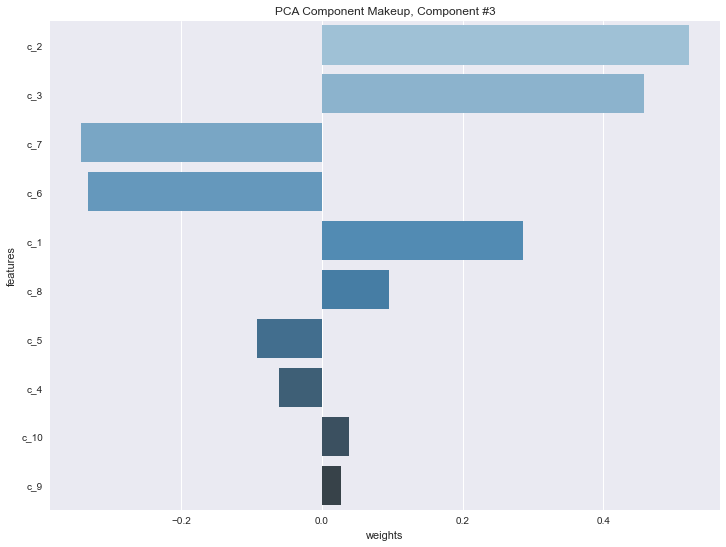

In [110]:
display_components(3,17)


### Extracting trained model attributes and visualizing clusters

Then we view the centroid of each cluster. The centroids would be used to observe the properties of each cluster.


## Visualizing the Centroids in Components Space¶

It won't be easy to visualize 12-dimensional centroids in component space. But a heatmap of the centroids and their components can be plotted in the transformed feature space. The heatmap would give insight into the characteristics that define each cluster

In [114]:
cluster_centroids = pd.DataFrame(gmm.means_, columns=transformed_dataframe.columns)
cluster_centroids

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10
0,-0.214160,0.210644,0.131286,0.120239,-0.012896,-0.077826,0.066666,-0.008949,0.007715,0.008713
1,-0.551436,-0.084683,-0.095363,-0.102048,0.010167,0.058503,-0.032851,0.003048,-0.010621,-0.005029
2,0.287139,-0.251121,0.034467,0.046962,-0.012403,-0.038634,0.012940,0.001890,0.006183,-0.002325
3,0.462836,0.182797,-0.058189,-0.055051,0.015143,0.053141,-0.041076,0.002839,-0.002772,0.000004


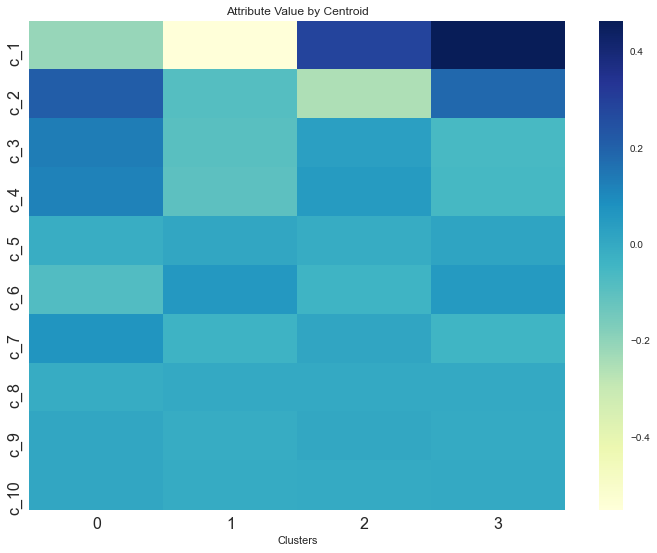

In [115]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sb.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Clusters")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

From the heatmap above, we see that:

- Cluster 0 is very high except in component 1.
- Cluster 1 is very high except in component 1.
- Cluster 2 is very high except in component 2.
- The variance between components 3 down to 10 isn't that significant.

In [53]:
customer_transactions_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         14825 non-null  float64
 1   gender                      14825 non-null  float64
 2   income                      14825 non-null  float64
 3   days_as_member              14825 non-null  float64
 4   total_completed             14825 non-null  float64
 5   total_viewed                14825 non-null  float64
 6   total_received              14825 non-null  float64
 7   percent_completed           14825 non-null  float64
 8   total_spent                 14825 non-null  float64
 9   avg_spent                   14825 non-null  float64
 10  num_transactions            14825 non-null  float64
 11  completed_bogo              14825 non-null  float64
 12  num_bogos                   14825 non-null  float64
 13  bogo_percent_completed      148

### Number of Clusters

First, let's determine the number of ideal clusters by viewing KMeans SSE scores as K increases as well as leveraging the silhouette score

In [54]:
#Building a function to quickly iterate through various KMeans models that takes in data and number of cluster as inputs
#Returns the appropriate k_means score
def kmeans_score(data, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [55]:
#Running the kmeans_score function for a number of different cluster patterns
scores = []
for i in range(1, 20):
    score = kmeans_score(customer_transactions_master, i)
    scores.append(score)



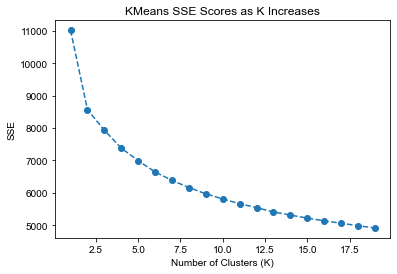

In [56]:
#Plotting results from the previous cell; noting that we begin seeing after about 4 clusters
centers = range(1, 20)
plt.plot(centers, scores, linestyle = '--', marker = 'o');
plt.style.use('seaborn');
plt.title('KMeans SSE Scores as K Increases');
plt.ylabel('SSE');
plt.xlabel('Number of Clusters (K)');

In [63]:
#Determining the silhouette score for the first 20 clusters
#Special thanks to this post for assistance: https://stackoverflow.com/questions/51149589/memorerror-while-calculating-silhouette-score

for i in range(2, 20):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(customer_transactions_master)
    clusters = kmeans.predict(customer_transactions_master)
    silhouette_avg = silhouette_score(customer_transactions_master, clusters)
    print("For n_clusters = ", i,"The avg silhouette_score is :", silhouette_avg)

For n_clusters =  2 The avg silhouette_score is : 0.34563481440633215
For n_clusters =  3 The avg silhouette_score is : 0.36225910479663387
For n_clusters =  4 The avg silhouette_score is : 0.25964869765424275
For n_clusters =  5 The avg silhouette_score is : 0.1690494000201967
For n_clusters =  6 The avg silhouette_score is : 0.16426608035740384
For n_clusters =  7 The avg silhouette_score is : 0.15331092053578937
For n_clusters =  8 The avg silhouette_score is : 0.1468250309154469
For n_clusters =  9 The avg silhouette_score is : 0.14906760038942352
For n_clusters =  10 The avg silhouette_score is : 0.14660499296752108
For n_clusters =  11 The avg silhouette_score is : 0.14673761337162686
For n_clusters =  12 The avg silhouette_score is : 0.1385323001091669
For n_clusters =  13 The avg silhouette_score is : 0.13767789144230955
For n_clusters =  14 The avg silhouette_score is : 0.11906444664195084
For n_clusters =  15 The avg silhouette_score is : 0.11712040302488348
For n_clusters = 


### Number of Clusters We Will Use: 4

Given both pieces here, we'll go ahead and leverage 4 clusters. Both the sihouette score and elbow method started showing diminishing returns following 4 clusters.


In [117]:
#Using the ward model, we'll append the results as a new column to our normalized master
ward_model = AgglomerativeClustering(n_clusters = 4)
customer_transactions_master['cluster'] = ward_model.fit_predict(customer_transactions_master)

In [118]:
customer_transactions_master.sample(10)

,age,gender,income,days_as_member,total_completed,total_viewed,total_received,percent_completed,total_spent,avg_spent,num_transactions,completed_bogo,num_bogos,bogo_percent_completed,completed_discount,num_discounts,discount_percent_completed,cluster
12595,0.180723,0.0,0.122222,0.196928,0.666667,0.500000,0.833333,0.800000,0.068901,0.021994,0.305556,0.25,0.166667,0.272727,0.50,0.411765,0.285714,0
14709,0.662651,0.0,0.244444,0.290181,0.333333,0.500000,0.833333,0.400000,0.039144,0.008969,0.416667,0.25,0.055556,1.000000,0.50,0.352941,0.333333,1
11407,0.734940,0.5,0.733333,0.106418,0.666667,0.333333,1.000000,0.666667,0.082887,0.058757,0.138889,0.25,0.111111,0.454545,1.00,0.529412,0.444444,0
11352,0.421687,0.0,0.288889,0.213385,0.333333,0.166667,0.500000,0.666667,0.060043,0.035337,0.166667,0.25,0.111111,0.454545,0.50,0.235294,0.500000,3
9033,0.542169,0.0,0.333333,0.071860,0.333333,1.000000,1.000000,0.333333,0.039716,0.035058,0.111111,0.25,0.111111,0.454545,0.75,0.470588,0.375000,3
1099,0.602410,0.5,0.644444,0.292375,0.500000,0.333333,0.666667,0.750000,0.129161,0.045706,0.277778,0.25,0.277778,0.127273,0.25,0.176471,0.333333,0
4104,0.397590,0.0,0.211111,0.074602,0.000000,0.666667,0.833333,0.000000,0.000000,0.031377,0.000000,0.50,0.222222,0.454545,0.25,0.235294,0.250000,1
11991,0.433735,0.5,0.700000,0.435546,0.500000,0.333333,0.666667,0.750000,0.088426,0.078464,0.111111,0.25,0.166667,0.272727,0.50,0.235294,0.500000,0
1867,0.481928,0.0,0.366667,0.911135,0.500000,1.000000,1.000000,0.500000,0.062293,0.007891,0.750000,0.50,0.388889,0.220779,0.25,0.352941,0.166667,3
13676,0.204819,0.0,0.033333,0.442128,0.500000,0.333333,0.833333,0.600000,0.062504,0.015581,0.388889,0.50,0.222222,0.454545,0.50,0.352941,0.333333,3


In [120]:
#Adding our clusters column back into our primary, unnormalized dataset for analyses
customer_transactions['cluster'] = customer_transactions_master['cluster']

In [121]:
customer_transactions.to_csv('customer_transactions_clusters.csv', index = False)

In [122]:
customer_transactions = pd.read_csv('customer_transactions_clusters.csv')

In [123]:
customer_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         14825 non-null  int64  
 1   gender                      14825 non-null  int64  
 2   income                      14825 non-null  float64
 3   days_as_member              14825 non-null  int64  
 4   total_completed             14825 non-null  int64  
 5   total_viewed                14825 non-null  int64  
 6   total_received              14825 non-null  int64  
 7   percent_completed           14825 non-null  float64
 8   total_spent                 14825 non-null  float64
 9   avg_spent                   14492 non-null  float64
 10  num_transactions            14825 non-null  int64  
 11  completed_bogo              14825 non-null  int64  
 12  num_bogos                   14825 non-null  int64  
 13  bogo_percent_completed      148

# Final machine learning Model Round

In [135]:
#Using the ward model, we'll add the results as a new column to our normalized master
ward_model = AgglomerativeClustering(n_clusters = 4)
customer_transactions_analysis['cluster'] = ward_model.fit_predict(customer_transactions_master)

In [136]:
customer_transactions_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 0610b486422d4921ae7d2bf64640c50b to e4052622e5ba45a8b96b59aba68cf068
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         14825 non-null  int64  
 1   age_range                   14825 non-null  object 
 2   gender                      14825 non-null  object 
 3   income                      14825 non-null  float64
 4   became_member_on            14825 non-null  object 
 5   days_as_member              14825 non-null  int64  
 6   total_completed             14825 non-null  int64  
 7   total_viewed                14825 non-null  int64  
 8   total_received              14825 non-null  int64  
 9   percent_completed           14825 non-null  float64
 10  total_spent                 14825 non-null  float64
 11  avg_spent                   14492 non-null  float64
 12  num_transactions            14825 n

In [137]:
customer_transactions_analysis.head(10)

,age,age_range,gender,income,became_member_on,days_as_member,total_completed,total_viewed,total_received,percent_completed,total_spent,avg_spent,num_transactions,completed_bogo,num_bogos,bogo_percent_completed,completed_discount,num_discounts,discount_percent_completed,cluster
customer_id,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,50-59,F,112000.0,2017-07-15,382,1,0,2,0.000000,77.01,25.670000,3,1,2,0.500000,0,0,0.000000,3
78afa995795e4d85b5d9ceeca43f5fef,75,70-79,F,100000.0,2017-05-09,449,3,4,4,0.750000,159.27,22.752857,7,3,9,0.333333,0,0,0.000000,0
e2127556f4f64592b11af22de27a7932,68,60-69,M,70000.0,2018-04-26,97,2,3,4,0.500000,57.73,19.243333,3,1,3,0.333333,2,5,0.400000,1
389bc3fa690240e798340f5a15918d5c,65,60-69,M,53000.0,2018-02-09,173,5,6,6,0.833333,36.43,12.143333,3,2,11,0.181818,2,6,0.333333,0
2eeac8d8feae4a8cad5a6af0499a211d,58,50-59,M,51000.0,2017-11-11,263,1,2,3,0.333333,15.62,3.905000,4,0,0,0.181818,2,5,0.400000,2
aa4862eba776480b8bb9c68455b8c2e1,61,60-69,F,57000.0,2017-09-11,324,3,5,5,0.600000,85.55,14.258333,6,3,9,0.333333,1,2,0.500000,0
e12aeaf2d47d42479ea1c4ac3d8286c6,26,20-29,M,46000.0,2014-02-13,1630,1,1,6,0.166667,56.22,5.110909,11,1,2,0.500000,2,6,0.333333,1
31dda685af34476cad5bc968bdb01c53,62,60-69,F,71000.0,2016-02-11,902,4,5,6,0.666667,160.25,20.031250,8,0,0,0.500000,3,15,0.200000,0
62cf5e10845442329191fc246e7bcea3,49,40-49,M,52000.0,2014-11-13,1357,1,2,3,0.333333,144.11,16.012222,9,1,3,0.333333,1,1,1.000000,1


## Final Analysis and Visualisations

Now that we have performed various unsupervised machine learning algorithms, lets visualise the data and find the gems in the data

## What are the defined personal attributes of our customers throughout each of our clusters?

Firstly, we will dive into the personal attributes of our customers as clustered by our algorithm. We'll visualise this in a PairPlot and make the diagrams very easy to understand.


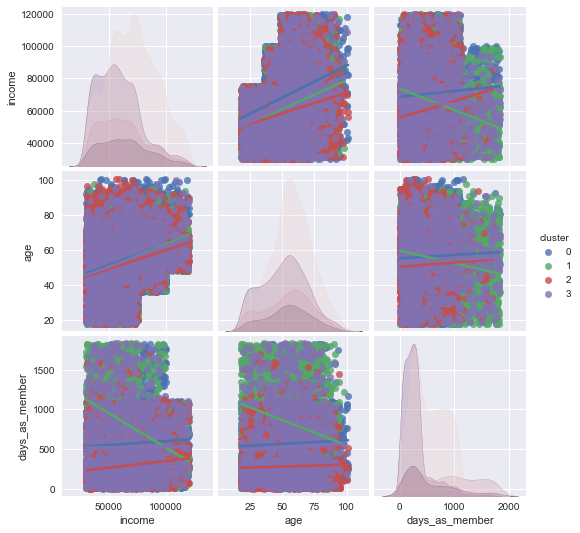

In [140]:
#Viewing personal customer details in a seaborn pairplot
#Check out this for seaborn plots : https://seaborn.pydata.org/generated/seaborn.pairplot.html
personal_details = ['gender', 'income', 'age', 'days_as_member', 'cluster']
sb.pairplot(customer_transactions_analysis[personal_details], hue = 'cluster', kind = 'reg');

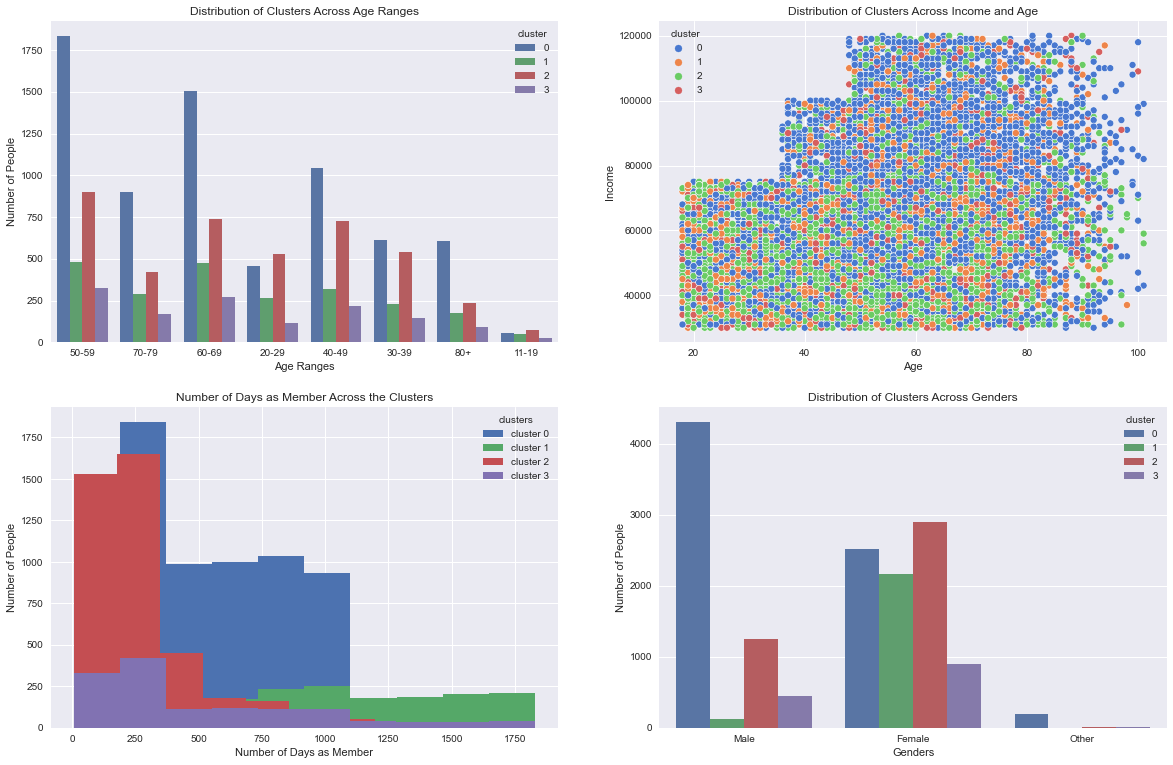

In [139]:
#Visualizing the personal details in closer details across each cluster
#Check out this post for assistance: https://stackoverflow.com/questions/1358977/how-to-make-several-plots-on-a-single-page-using-matplotlib
#Check out this post for assistance: https://stackoverflow.com/questions/19626530/python-xticks-in-subplots

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 13))

#Visualizing clusters across age ranges
sb.countplot(data = customer_transactions_analysis, x = 'age_range', hue = 'cluster', ax = axes[0,0]);
axes[0,0].set_title('Distribution of Clusters Across Age Ranges');
axes[0,0].set_xlabel('Age Ranges');
axes[0,0].set_ylabel('Number of People');

#Visualizing clusters across incomes and ages
sb.scatterplot(data = customer_transactions_analysis, x = 'age', y = 'income', hue = 'cluster', palette = sb.color_palette('muted', n_colors = 4), ax = axes[0,1]);
axes[0,1].set_title('Distribution of Clusters Across Income and Age');
axes[0,1].set_xlabel('Age');
axes[0,1].set_ylabel('Income');

#Visualizing how long members have been members in a stacked histogram
days_as_member_0 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 0]['days_as_member']
days_as_member_1 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 1]['days_as_member']
days_as_member_2 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 2]['days_as_member']
days_as_member_3 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 3]['days_as_member']
axes[1,0].hist(days_as_member_0, stacked = True);
axes[1,0].hist(days_as_member_1, stacked = True);
axes[1,0].hist(days_as_member_2, stacked = True);
axes[1,0].hist(days_as_member_3, stacked = True);
axes[1,0].legend(title = 'clusters', labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']);
axes[1,0].set_title('Number of Days as Member Across the Clusters');
axes[1,0].set_xlabel('Number of Days as Member');
axes[1,0].set_ylabel('Number of People');

#Visualizing clusters across age ranges
sb.countplot(data = customer_transactions_analysis, x = 'gender', hue = 'cluster', ax = axes[1,1]);
axes[1,1].set_title('Distribution of Clusters Across Genders');
axes[1,1].set_xlabel('Genders');
axes[1,1].set_ylabel('Number of People');
plt.sca(axes[1,1]);
plt.xticks(range(3), ['Male', 'Female', 'Other']);



##  Analysis of Clustered Personal Attributes
There are lot of insights to glean from this visulisation. Lets cover each of this clusters with clusters below 



### Cluster 0

This is the largest cluster, cluster 0 seems to consist of older people with higher incomes. As shown by the countplot with the age ranges, the ages of these people tend to falls into that 50 to 80 year old range. It's actually very common to see the same sets of people have some of the higher income ranges. Gender was relatively split with men accounting for slightly a little more, This might have to do with the fact that the original dataset  collected more data with men actually. Although this cluster was the biggest,it did have a lot of discrepancies especially with income and that makes it unreliable for future inferences. 

### Cluster 1

This cluster would seem like like the cluster filled with young people. Looking at the age range distribution, we see the strongest distrubution here amongst the 20-40 year old. There seems to be a significant gap between males and females in this cluster . The people in this cluster also seem to fall in the low income range. And asfar as number of days as member goes, this cluster's distribution is very similar to that of cluster 0.

### Cluster 2
There seem to be more females than males in this cluster and the cluster showed the largest distribution for strbucks reward . it was not suprising that income tended to be higher for tis group given from our initial analysis that men seemed to make more than women.


### Cluster 3

This cluster is the smallest of our four clusters,yet it is very similar to cluster 0 in a few ways. Basically the distribution of days as member and gender are fairly similar. Perhaps the exception that separates it from cluster 0 is that there tended to be more people in the younger age range, and I suppose that would make sense given that younger people consisted of a smaller subset of the original data provided.
Q6: What do the behavioral attributes look like across our clusters?

Finally, let's wrap up our analysis by looking at the clusters across some of the more behavioral attributes.


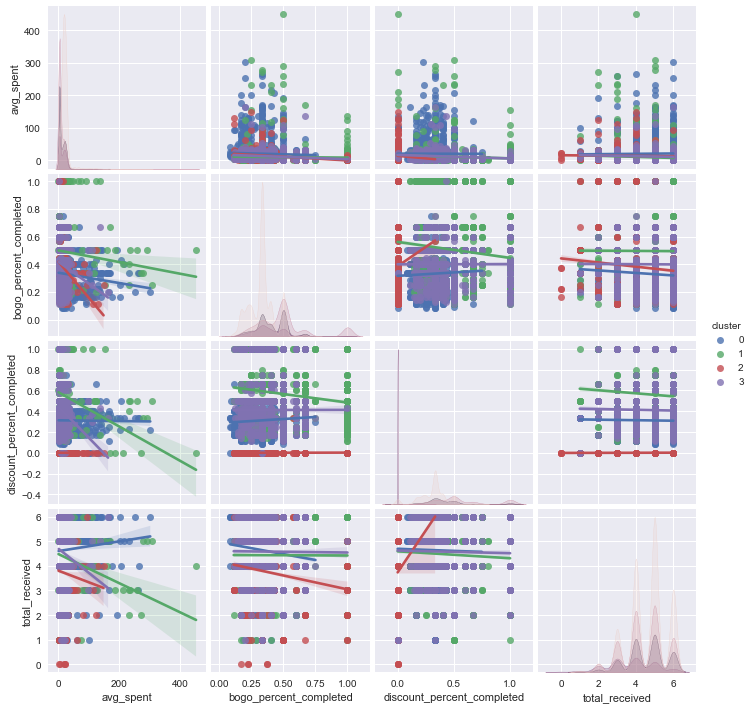

In [89]:
behavioral_attributes = ['cluster', 'avg_spent', 'bogo_percent_completed', 'discount_percent_completed', 'total_received']
sb.pairplot(customer_transactions_analysis[behavioral_attributes], hue = 'cluster', kind = 'reg');

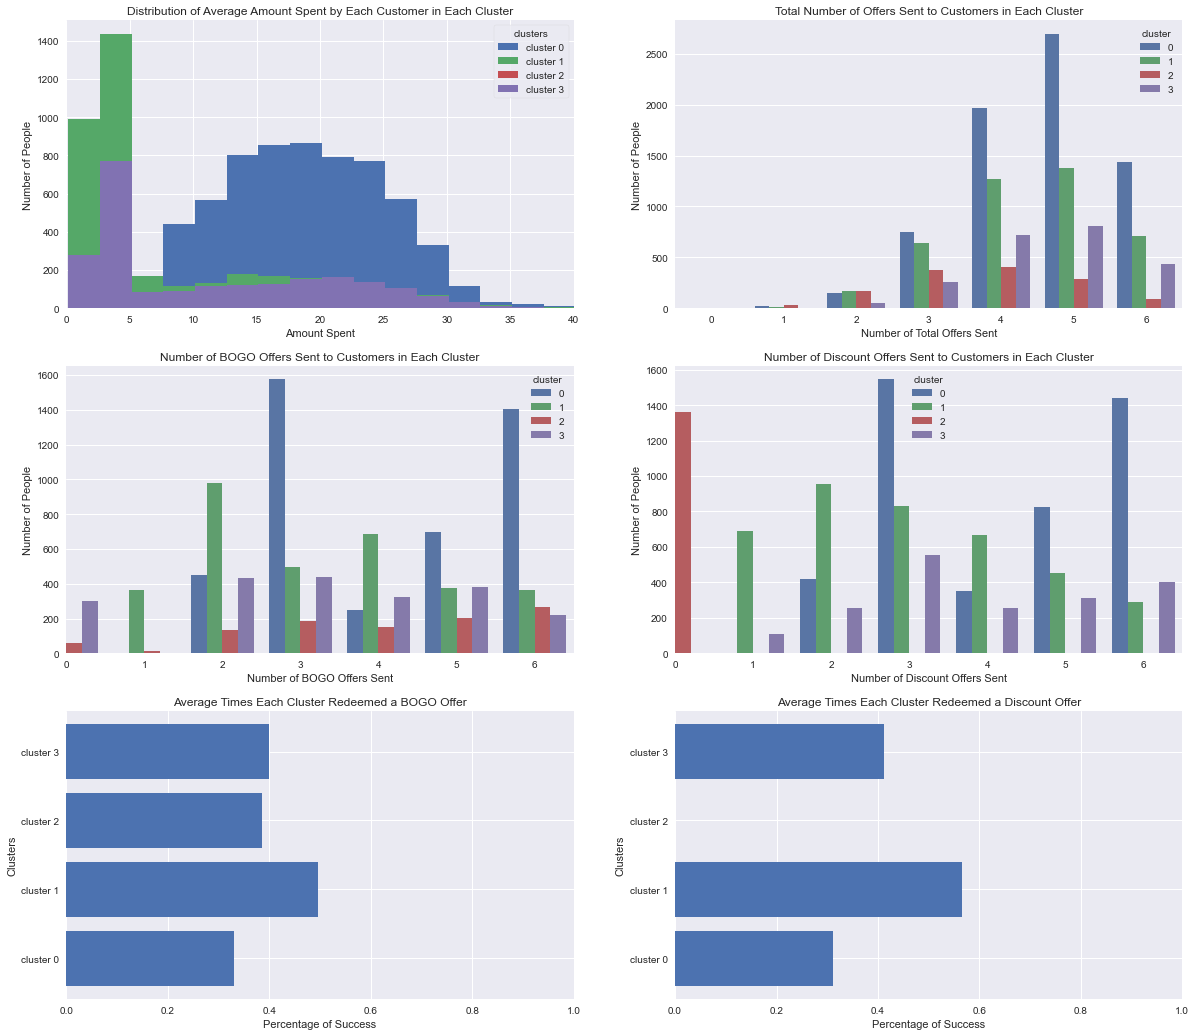

In [90]:
#Visualizing the behavioral attributes in more detail
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 18))

#Visualizing the average amount spent by customers in each respective cluster
avg_spent_0 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 0]['avg_spent']
avg_spent_1 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 1]['avg_spent']
avg_spent_2 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 2]['avg_spent']
avg_spent_3 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 3]['avg_spent']
avg_spent_bins = np.arange(min(customer_transactions_analysis['avg_spent']), max(customer_transactions_analysis['avg_spent'] + 2.5), 2.5)
axes[0,0].hist(avg_spent_0, bins = avg_spent_bins, stacked = True);
axes[0,0].hist(avg_spent_1, bins = avg_spent_bins, stacked = True);
axes[0,0].hist(avg_spent_2, bins = avg_spent_bins, stacked = True);
axes[0,0].hist(avg_spent_3, bins = avg_spent_bins, stacked = True);
axes[0,0].set_xlim([0, 40]);
axes[0,0].legend(title = 'clusters', labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'], frameon = True);
axes[0,0].set_title('Distribution of Average Amount Spent by Each Customer in Each Cluster');
axes[0,0].set_xlabel('Amount Spent');
axes[0,0].set_ylabel('Number of People');

#Visualizing the total number of offers sent to the customers
sb.countplot(data = customer_transactions_analysis, x = 'total_received', hue = 'cluster', ax = axes[0,1]);
axes[0,1].set_title('Total Number of Offers Sent to Customers in Each Cluster');
axes[0,1].set_xlabel('Number of Total Offers Sent');
axes[0,1].set_ylabel('Number of People');

#Visualizing the number of BOGO offers sent to the customers
sb.countplot(data = customer_transactions_analysis, x = 'num_bogos', hue = 'cluster', ax = axes[1,0]);
axes[1,0].set_title('Number of BOGO Offers Sent to Customers in Each Cluster');
axes[1,0].set_xlabel('Number of BOGO Offers Sent');
axes[1,0].set_ylabel('Number of People');
axes[1,0].set_xlim([0, 6.5]);

#Visualizing the number of discount offers sent to the customers
sb.countplot(data = customer_transactions_analysis, x = 'num_discounts', hue = 'cluster', ax = axes[1,1]);
axes[1,1].set_title('Number of Discount Offers Sent to Customers in Each Cluster');
axes[1,1].set_xlabel('Number of Discount Offers Sent');
axes[1,1].set_ylabel('Number of People');
axes[1,1].set_xlim([0, 6.5]);

#Visualizing the mean of the how often customers completed bogo offers in each cluster
bogo_pct_completed_0 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 0]['bogo_percent_completed'].mean()
bogo_pct_completed_1 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 1]['bogo_percent_completed'].mean()
bogo_pct_completed_2 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 2]['bogo_percent_completed'].mean()
bogo_pct_completed_3 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 3]['bogo_percent_completed'].mean()
bogo_pct_completed_data = [bogo_pct_completed_0, bogo_pct_completed_1, bogo_pct_completed_2, bogo_pct_completed_3]
y_pos = np.arange(len(bogo_pct_completed_data))
bogo_tick_labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']
axes[2,0].barh(y_pos, bogo_pct_completed_data, tick_label = bogo_tick_labels);
axes[2,0].set_xlim([0, 1]);
axes[2,0].set_title('Average Times Each Cluster Redeemed a BOGO Offer');
axes[2,0].set_xlabel('Percentage of Success');
axes[2,0].set_ylabel('Clusters');

#Visualizing the mean of the how often customers completed discount offers in each cluster
discount_pct_completed_0 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 0]['discount_percent_completed'].mean()
discount_pct_completed_1 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 1]['discount_percent_completed'].mean()
discount_pct_completed_2 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 2]['discount_percent_completed'].mean()
discount_pct_completed_3 = customer_transactions_analysis[customer_transactions_analysis['cluster'] == 3]['discount_percent_completed'].mean()
discount_pct_completed_data = [discount_pct_completed_0, discount_pct_completed_1, discount_pct_completed_2, discount_pct_completed_3]
y_pos = np.arange(len(discount_pct_completed_data))
discount_tick_labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']
axes[2,1].barh(y_pos, discount_pct_completed_data, tick_label = discount_tick_labels);
axes[2,1].set_xlim([0, 1]);
axes[2,1].set_title('Average Times Each Cluster Redeemed a Discount Offer');
axes[2,1].set_xlabel('Percentage of Success');
axes[2,1].set_ylabel('Clusters');


#discount_percent_cmompleted
#bogo_percent_completed




## Analysis of Clustered Behavioral Attributes
We dive into a deeper perspective of the behavioural attributes of these customers 

### Cluster 0

First This cluster on average seems to be the biggest spenders, with an average transaction total peaking at ~\$19. This amount is really high, This is actualy in tune with our previous observation due to the fact that this particular cluster contains our older customers, which we have establised that have an higher income. Also more likely than not this cluster probably have families and these customers are buying coffee for multiple people. Considering all these it makes sense the average number makes more sense.

This cluster has the lowest yield of using discount offers and pretty close to last for BOGO offers. This might make more sense beacuse these clusters might be made of older customers who might not take full advantage of the BOGO offers being sent out eletronically . Also this might be that stabucks does not see any interest in trying to appeal to groups that historically dont take advantage of their offers .

### Cluster 1

We miht recall that this cluster is more of a younger nature and therefore we see the average amoun spend towards the lower end. However We see that this particular group utilises the offers and take advantage of the offers for Bogo more that the discount offers . The success levels for both are 40\% and this might because the diffuclty level to claim these rewards are high 

### Cluster 2

This cluster is predominatly female as established earlier and have an high spend amount, much the same as cluster 0. This cluster makes use of the offers especially the Bogo offers. I am not sure particularly why this is but personally i think there's a lot of are of improvement for this cluster given the demographic information of this group


### Cluster 3


This cluster was the hardest to read of all clusters because even though the group's demographic aligned to that of Cluster 0's it tended to have a lot of younger age range. This group has a  high of a success rate with offers, especially with discount based offers. Even though this is the  smallest of the clusters, I would personally recomend that starbucks leans more into this cluster to discover what is causing the level of success.

